# CT Images

Silia Georgaki

# Description

**Spatial Image Registration**

1.  Read the .raw files using the information provided in the .mhd
    files.
2.  Select slices 286 from CT1 and 372 from CT2.
3.  Project the edges of slice 372 onto slice 286.
4.  Choose corresponding points in the two slices, in areas unaffected
    by elastic deformation.
5.  Calculate the matrix of affine geometric transformation required to
    align the selected corresponding points.
6.  Apply the transformation to the image of CT2.

Replace step 4 of the exercise so that the selection of points is not
done manually by the user but by using characteristic points, employing
image features such as SURF, SIFT, etc.

# Import Packages

In [1]:
import SimpleITK as sitk
import cv2
import numpy as np
%matplotlib tk
import matplotlib.pyplot as plt
import time

# A) Read raw files using information from mhd files

In [2]:
# File names
mhd1_file = '01_Fixed.mhd'
mhd2_file = '01_Moving.mhd'

# Read Files
ct1 = sitk.ReadImage(mhd1_file)
ct2 = sitk.ReadImage(mhd2_file)

# This can be used to to have acess to more information 

#  def read_files(mha_file): #Set up the reader and get the file information.
#  file_reader = sitk.ImageFileReader()
#  file_reader.SetFileName(mha_file)   # Give it the mha file as a string
#  file_reader.LoadPrivateTagsOn()     # Make sure it can get all the info
#  file_reader.ReadImageInformation()  # Get just the information from the file
#  return (file_reader) #returns the info for each img

# B) Plots

In [3]:
# Choose slices
slice_286_ct1 = sitk.GetArrayFromImage(ct1)[286, :, :]
slice_372_ct2 = sitk.GetArrayFromImage(ct2)[372, :, :]

# Display slice 286
plt.imshow(slice_286_ct1, cmap = 'gray')
plt.title('Slice 286')
plt.savefig("slice_286.png")

# Display slice 372
plt.imshow(slice_372_ct2, cmap = 'gray')
plt.title('Slice 372')
# Save the plot as an image file
plt.savefig("slice_372.png")

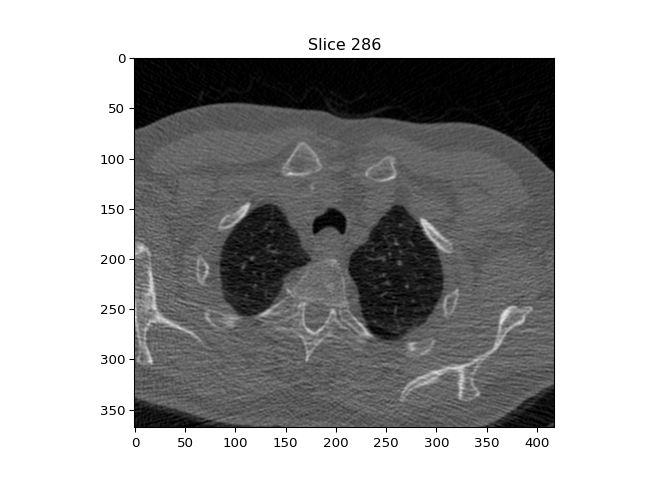 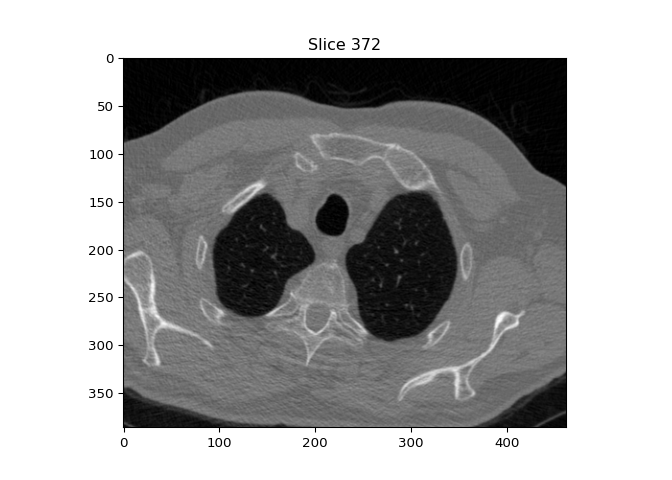

# C) Project the edges of 372 onto 286

In [4]:
# Apply Gaussian blur to the image before Sobel edge detection
blurred_slice_372_ct2 = cv2.GaussianBlur(slice_372_ct2, (7, 7), 0)

# Sobel for edge detection
edges_372 = cv2.Sobel(blurred_slice_372_ct2, cv2.CV_64F, 1, 0, ksize = 3)
edges_372 = cv2.convertScaleAbs(edges_372)

# Thresholding to obtain binary image
_, threshold_img_372 = cv2.threshold(edges_372, 150, 255, cv2.THRESH_BINARY)

# Display binary image
plt.imshow(threshold_img_372, cmap = 'gray')
plt.title('Binary image')
plt.show()

# Find the contours from the thresholded image
contours, hierarchy = cv2.findContours(threshold_img_372, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

# Clone slices and save as png
clone_286 = slice_286_ct1.copy()
clone_286 = plt.imsave("Clone_286.png", clone_286, cmap = 'gray')
clone_286 = cv2.imread("Clone_286.png")
# To draw contours on it
clone_286_to_contour = clone_286.copy()
clone_372 = slice_372_ct2.copy()
clone_372 = plt.imsave("Clone_372.png", clone_372, cmap = 'gray')
clone_372 = cv2.imread("Clone_372.png")

# Find the largest areas
largest_areas = sorted(contours, key = cv2.contourArea)

# Draw the contours on the mask in yellow
for i in range (-65,0):
    projection = cv2.drawContours(clone_286_to_contour, [largest_areas[i]],  -1, (255, 255, 0), 2, lineType = cv2.LINE_AA)

# Display slice projection
plt.imshow(projection, cmap = 'gray')
plt.title('Projection')
plt.savefig("projection.png")

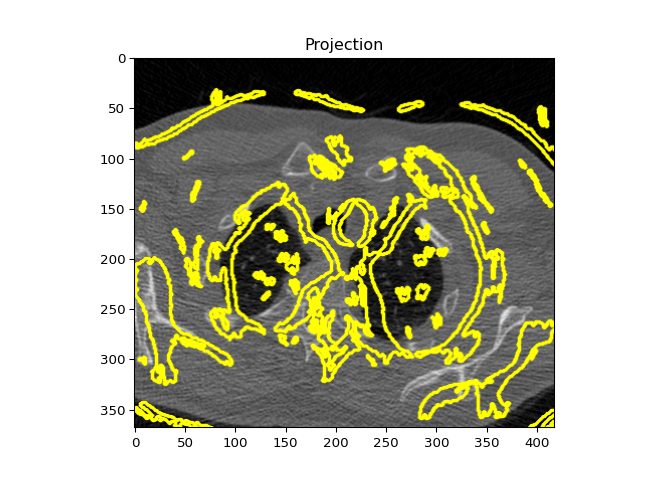

# D) Choose points

The points selected in this step are used later on steps E and F.

In [5]:
# Get points of slice 286
plt.title('Click on the image to get 3 points.')
plt.imshow(slice_286_ct1 , cmap = 'gray')
CT1_points = plt.ginput(3) 
plt.show()
plt.close()
print("Points selected on CT-1: ", CT1_points)

# Get points of slice 372
plt.title('Click on the image to get 3 points.')
plt.imshow(slice_372_ct2, cmap = 'gray')
CT2_points = plt.ginput(3) 
plt.show()
plt.close()
print("Points selected on CT-2: ", CT2_points) 

Points selected on CT-1:  [(167.27922077922076, 302.58225108225105), (202.12770562770558, 257.7770562770562), (165.28787878787878, 247.8203463203463)]
Points selected on CT-2:  [(195.61796536796535, 320.5400432900433), (225.90476190476184, 268.32142857142856), (191.44047619047618, 255.78896103896105)]

# E) Affine transformation

In [6]:
# Convert the list of tuples to a 2D array
CT1_coords = np.array( [ [x, y] for x,y in  CT1_points ] )
CT2_coords = np.array( [ [x, y] for x,y in  CT2_points ] )

# Print the resulting array (3x2).
print("\n  CT-1:  points' coordinates \n\n", CT1_coords)
print("\n\n\n  CT-2:  points' coordinates \n\n", CT2_coords)

# Create matrix X(3x1).
X = np.array( [ [x[0]] for x in  CT2_coords ] )
print("\n\n \t  X \n", X)
# Create matrix Y(3x1).
Y = np.array( [ [y[1]] for y in  CT2_coords ] )
print("\n\n \t  Y \n", Y)

# Create a column of ones(3x1) with the same shape as the array.
ones = np.ones((CT1_coords.shape[0], 1))

# Stack the column of ones to the right of the array, inorder to create matrix M(3x3).
M = np.column_stack((CT1_coords, ones))
print("\n\n \t  M \n", M)
# Calculate the transpose of the matrix M(3x3).

M_t = np.transpose(M)  #or  M_t = M.T
print("\n\n \t  (M)' \n", M_t)

# Multiply matrix M with its transpose.
M_txM = np.dot(M_t, M)

# Calculate the inverse of (M)'x M
inverseM_txM = np.linalg.inv(M_txM)

A1 = np.dot( np.dot(inverseM_txM, M_t),  X ) 
A2 = np.dot( np.dot(inverseM_txM, M_t),  Y ) 

# Create the affine transformation matrix by stacking the matrices-vectors vertically.
AffineT = np.vstack((A1.T, A2.T))


  CT-1:  points' coordinates 

 [[167.27922078 302.58225108]
 [202.12770563 257.77705628]
 [165.28787879 247.82034632]]



  CT-2:  points' coordinates 

 [[195.61796537 320.54004329]
 [225.9047619  268.32142857]
 [191.44047619 255.78896104]]


      X 
 [[195.61796537]
 [225.9047619 ]
 [191.44047619]]


      Y 
 [[320.54004329]
 [268.32142857]
 [255.78896104]]


      M 
 [[167.27922078 302.58225108   1.        ]
 [202.12770563 257.77705628   1.        ]
 [165.28787879 247.82034632   1.        ]]


      (M)' 
 [[167.27922078 202.12770563 165.28787879]
 [302.58225108 257.77705628 247.82034632]
 [  1.           1.           1.        ]]

# F) Apply Affine Transformation and SIFT

In [7]:
# Apply the affine transformation onto No. 372 intersection of CT-2.
transformed_image = cv2.warpAffine(slice_372_ct2, AffineT, (slice_372_ct2.shape[1], slice_372_ct2.shape[0]))
transformed = plt.figure('Affine Trasnformation')
plt.imshow(transformed_image, cmap = 'gray')
plt.title('Affine Transformation')
plt.savefig("transformed_image.png")

# SIFT
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(clone_286,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(clone_372,None)
len(keypoints_1), len(keypoints_2)

# Feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

imgSIFT = cv2.drawMatches(clone_372, keypoints_1, clone_286, keypoints_2, matches[:50], clone_286, flags = 2)
plt.imshow(imgSIFT)
plt.title('Feature Matching Using SIFT')
plt.savefig("sift.png")

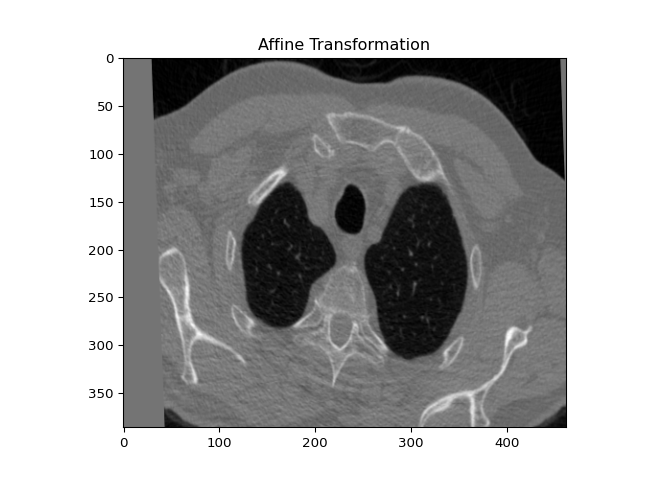
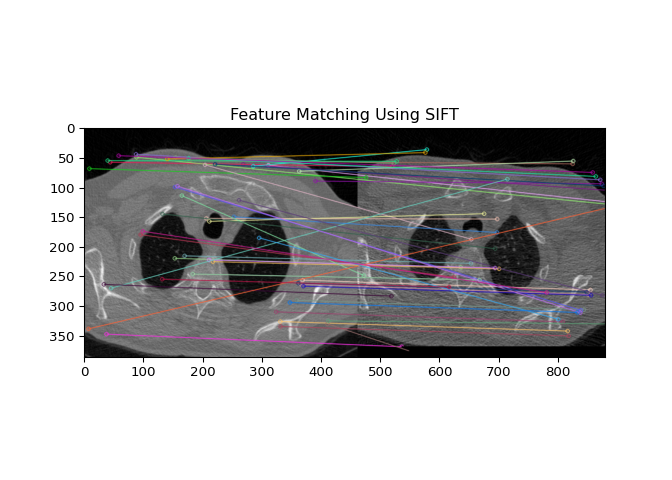